In [127]:
## Import libraries
#general
import pandas as pd
import os
import numpy as np
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
import re
from sklearn.externals.six import StringIO


#visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [13]:
## Read in data
data = pd.read_csv('monster_com-job_sample.csv')
data.columns

Index([u'country', u'country_code', u'date_added', u'has_expired',
       u'job_board', u'job_description', u'job_title', u'job_type',
       u'location', u'organization', u'page_url', u'salary', u'sector',
       u'uniq_id'],
      dtype='object')

In [14]:
## Parse salary data and prepare dataset
#data['numbers']=''
data['yearly'] = ''
data['hourly'] =''
data['full_time']=''
data['part_time']=''
data['analyst']=''

for index in data.salary.index:

    #data['numbers'][index]=bool(re.match(r'([0-9]+[^0-9]+)',str(data.salary[index])))
    data['yearly'][index]=bool(re.search('\$ /year',str(data.salary[index])))
    data['hourly'][index]=bool(re.search('\$ /hour',str(data.salary[index])))
    data['full_time'][index]=bool(re.search('Full Time',str(data.job_type[index])))
    data['part_time'][index]=bool(re.search('(part)|(Part)',str(data.job_type[index])))
    data['analyst'][index]=bool(re.search('(analyst)|(Analyst)',str(data.job_title[index])))

#extract salary ranges
ranges=data.salary.str.extract(r'([0-9\.\,\s]+.\-[0-9\.\,\s]+)',expand=True).rename(columns={0:'ranges'})
data=data.join(ranges)

#extract numbers
numbers=data.salary.str.extract(r'([0-9]+\s)',expand=True,).rename(columns={0:'numbers'})
data=data.join(numbers)

#parse salary ranges
df=data['ranges'].str.split('-',expand=True).rename(columns={0:'lowest',1:'highest'})
data=data.join(df)

#convert columns to numeric
numeric=pd.Index([u'lowest',u'highest',u'numbers'])

for i in numeric:
    data[i]=data[i].str.replace(' ','')
    data[i]=data[i].str.replace(',','')
    data[i]=pd.to_numeric(data[i])





KeyboardInterrupt: 

In [269]:
#convert units of hours into units of years
for index in data.salary.index:
        for i in numeric:
            if (data.hourly[index]==True):
                if(data.part_time[index]==False):
                    data[i][index]=data[i][index]*40*52
                else:
                   data[i][index]=data[i][index]*20*52

C:\Users\daherg\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\daherg\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


KeyboardInterrupt: 

In [2]:
#get midpoint data for ranges
data['midpoint_salary']=(data['lowest']+data['highest'])/2

#add non-range salaries to midpoints column
for index in data.salary.index:
    if(pd.isnull(data.ranges[index])&pd.notnull(data.numbers[index])):
        data.midpoint_salary[index]=data.numbers[index]

NameError: name 'data' is not defined

In [2]:
#write cleaned data to csv
#data.to_csv('monster_com-job_sample_cleaned.csv')

NameError: name 'data' is not defined

In [133]:
data=pd.read_csv('monster_com-job_sample_cleaned.csv')
#remove nan's
data=data.dropna(subset=['midpoint_salary'])

#only yearly and hourly salary
data=data[data.yearly|data.hourly]

In [134]:
#only include non-bogus salaries. The lowest possible minimum wage job in the US pays at least $7/hour
part_time_min=7*20*52
full_time_min=7*40*52

# filter out any salaries lower than $7/hour
data=data[((data.lowest>=part_time_min)&(data.highest>=part_time_min)&(data.part_time==True))|((data.lowest>=full_time_min)&(data.highest>=full_time_min)&(data.part_time==False))]

# filter out any salaries larger than $9,000,000 a year. Jobs claiming to pay more than that on a job board site would be a bit suspect.
data=data[data.highest<=9000000]

# filter out only salaries in the US, our country of interest.
data=data[data.country_code=='US']

# filter out only full time salaries, as these are what interests us
data=data[data.part_time==False]

# make states column
states=r'(AK|AL|AR|AZ|CA|CO|CT|DE|FL|GA|HI|IA|ID|IL|IN|KS|KY|LA|MA|MD|ME|MI|MN|MO|MS|MT|NC|ND|NE|NH|NJ|NM|NV|NY|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VA|VT|WA|WI|WV|WY)'

state=data.location.str.extract(states,expand=True,).rename(columns={0:'state'})
data=data.join(state)


# make bins
#bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000,150000,160000,170000,180000,190000,200000,300000,400000,500000,600000,700000,800000,900000]
data['midpoint_salary_bins']=pd.cut(data['midpoint_salary'],bins=100)

# assign bins to numbers
le = LabelEncoder()
data.midpoint_salary = le.fit_transform(data.midpoint_salary_bins)
data.head()

,Unnamed: 0,country,country_code,date_added,has_expired,job_board,job_description,job_title,job_type,location,...,full_time,part_time,analyst,ranges,numbers,lowest,highest,midpoint_salary,state,midpoint_salary_bins
13,13,United States of America,US,NaN,No,jobs.monster.com,Launch your teaching career with the Leader in...,Primrose Private Preschool Teacher Job in Houston,Full Time,"Houston, TX 77098",...,True,False,False,9.00 - 13.00,0.0,18720.0,27040.0,0,TX,"(14670.24, 24897.6]"
14,14,United States of America,US,NaN,No,jobs.monster.com,Construction Professional For more than 15 yea...,Superintendent Job in Houston,Full Time Employee,"Houston, TX",...,True,False,False,"80,000.00 - 95,000.00",0.0,80000.0,95000.0,7,TX,"(80683.2, 89980.8]"
19,19,United States of America,US,NaN,No,jobs.monster.com,"Competitive compensation package, excellent co...",Technician - Robot & Multi-Axis CNC Field Serv...,Full Time,"Carter Lake, IA 51510",...,True,False,False,"60,000.00 - 72,000.00",0.0,60000.0,72000.0,5,IA,"(62088.0, 71385.6]"
29,29,United States of America,US,NaN,No,jobs.monster.com,Experis is working with a Pharmaceutical start...,Sr. Process Engineer,Full Time Employee,"Sr. Process Engineer, Manufacturing",...,True,False,False,"70,000.00 - 100,000.00",0.0,70000.0,100000.0,7,NaN,"(80683.2, 89980.8]"
30,30,United States of America,US,NaN,No,jobs.monster.com,The world's largest standalone medical technol...,Mechanical Engineer - FEA/Mechanical Modeling/...,Full Time Temporary/Contract/Project,"Mounds View, MN 55112",...,True,False,False,62.00 - 81.00,0.0,128960.0,168480.0,14,MN,"(145766.4, 155064.0]"


In [135]:
#fix sector information
i='sector'

data['sector']=data['sector'].str.replace(' ','')
data['sector']=data['sector'].str.replace(',','')


In [136]:
#check min and max salaries
print('max:',data.midpoint_salary.max())
print('min:',data.midpoint_salary.min())
#data.sort_values(by='midpoint_salary',ascending=False)

('max:', 26)
('min:', 0)


In [137]:
# remove data point 7194, as it is highly unlikely that a picker/packer makes $900/hour
data=data.drop(7194)

In [138]:
## Prepare data for linear model and run

#onehotencode variables using dummies and separate out dependent and independent features
df=pd.get_dummies(data[['sector']],drop_first=False)
y=data['midpoint_salary']

#split into training and test set
X_train_1, X_test_1, y_train_1,y_test_1 = train_test_split(df,y,test_size=.22)

#run model
lm=LogisticRegression()
lm.fit(X_train_1,y_train_1)

 
y_pred_test=lm.predict(X_test_1)



print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test_1, y_pred_test)))


#print("Cross-validated mean accuracy:",cross_val_score(lm, df, y, cv=10, scoring='accuracy').mean())
print('coefficient: ',lm.coef_)
print('intercept: ',lm.intercept_)

#coefficients = pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)
#coefficients


('Training set RMSE:', 4.4195245185084069)
('coefficient: ', array([[-0.0638385 , -1.71174857, -0.37941474, ..., -0.12106999,
        -0.0638385 , -0.0638385 ],
       [-0.12282244, -1.17201811,  0.43168728, ..., -0.22459282,
        -0.12282244, -0.12282244],
       [-0.09029294,  0.40981512,  0.63624827, ..., -0.16832052,
        -0.09029294,  0.80386477],
       ..., 
       [-0.00431202, -0.3882456 , -0.03351005, ..., -0.00858751,
        -0.00431202, -0.00431202],
       [-0.0042427 , -0.38370756, -0.03298402, ..., -0.00844993,
        -0.0042427 , -0.0042427 ],
       [-0.00453244, -0.4024867 , -0.03517151, ..., -0.0090245 ,
        -0.00453244, -0.00453244]]))
('intercept: ', array([-2.62055072, -1.84288371, -2.21815791, -2.31211188, -2.32052679,
       -2.09902039, -2.40463273, -2.57467332, -2.61980456, -2.6763736 ,
       -3.25661186, -3.51499189, -4.70171594, -4.28376801, -4.2737098 ,
       -4.86707058, -5.31434866, -4.92300212, -5.01395785, -5.46978065,
       -5.15368803, 

Lets try imposing some polynomial features

Some of the sector features seem to not be sectors at all (e.g. CareerLevelEntryLevel). This confuses the dataset, as I  we do not have good information for this on every job posting. I will remove this and other offending rows to see if there will be an improvement.

In [118]:
#remove offending rows
data_cleaned=data[(data.sector!='Student(Undergraduate/Graduate)')&(data.sector!='Experienced(Non-Manager)')&(data.sector!='CareerLevelEntryLevel')&(data.sector!='CareerLevelExperienced(Non-Manager)')&(data.sector!='EntryLevel')&(data.sector!='Student(HighSchool)')]

## Prepare data for linear model and run

#onehotencode variables using dummies and separate out dependent and independent features
df=pd.get_dummies(data_cleaned[['sector']],drop_first=False)
y=data_cleaned['midpoint_salary']

#split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df,y,test_size=.22)

#run model
lm=LogisticRegression()
lm.fit(X_train,y_train)

#print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test)



print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

coefficients = pd.concat([pd.DataFrame(df.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)
coefficients
print("Cross-validated mean accuracy:",cross_val_score(lm, df, y, cv=10, scoring='accuracy').mean())

('Cross-validated mean accuracy:', 0.18476746542634961)


The model did not benefit much from removing those values. Let's leave them in for now. Let's filter for analyst positions

In [119]:
# only include analyst positions
data2=data[data.analyst==True]


In [125]:
# onehotencode variables using dummies and separate out dependent and independent features
df2=pd.get_dummies(data2[['sector']],drop_first=False)
#df=pd.get_dummies(data2['part_time'],drop_first=True)
#df2=df2.join(df)
y=data2['midpoint_salary']

# Split into training and test set
#X_train, X_test, y_train,y_test = train_test_split(df2,y,test_size=.22)

# run model
lm=LogisticRegression()
#lm.fit(X_train,y_train)
print("Cross-validated mean accuracy:",cross_val_score(lm, df2, y, cv=10, scoring='accuracy').mean())

('Cross-validated mean accuracy:', 0.18177308802308803)


In [88]:
# Check the model
coefficients = pd.concat([pd.DataFrame(df2.columns),pd.DataFrame(np.transpose(lm.coef_))], axis = 1)

print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test)
coefficients

('intercept: ', 5.8684210526315788)


,0,0
0,sector_Administrative/Clerical,-1.868421
1,sector_CustomerSupport/ClientCare,-4.868421
2,sector_EntryLevel,-3.868421
3,sector_Experienced(Non-Manager),-0.413876
4,sector_General/Other:Accounting/Finance,1.131579
5,sector_HumanResources,1.131579
6,sector_IT/SoftwareDevelopment,-0.201754
7,sector_Manager(Manager/SupervisorofStaff),-4.868421
8,sector_Marketing/Product,-2.868421
9,sector_Project/ProgramManagement,2.131579


In [89]:
print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
data2.shape

('Training set RMSE:', 4.4663195333439072)


(105, 27)

The model is still waaaaaaay off. It seems that number of features is roughly equal to the number of rows. Imputing values is not a good option, since the majority of the dataset is missing plausible values for the thing we want to predict, i.e. salary. If I want to do an analysis for analyst only positions, I may need to get a bigger dataset with more positions. 

Also, since there are  only categorical variables here, perhaps linear regression doesn't make sense. Let's try decision trees.

In [128]:
## Use a decision tree to look at what variables are most important
#use the same train/test split to run a decision tree
random_forest = RandomForestRegressor()
print("Cross-validated mean accuracy:",cross_val_score(lm, df2, y, cv=10, scoring='accuracy').mean())
#random_forest.fit(X_train_1,y_train_1)
#print("Random Forest RMSE:",np.sqrt(metrics.mean_squared_error(y_test_1,random_forest.predict(X_test_1))))


decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train_1,y_train_1)
print("Decision Tree RMSE:",np.sqrt(metrics.mean_squared_error(y_test_1,decision_tree.predict(X_test_1))))


('Cross-validated mean accuracy:', 0.18177308802308803)
('Decision Tree RMSE:', 3.4604874845383322)


In [132]:
rf_2 = RandomForestClassifier(max_depth=2, random_state=1)
print("Cross-validated mean accuracy for depth 2:",cross_val_score(rf_2, df2, y, cv=10, scoring='accuracy').mean())

('Cross-validated mean accuracy for depth 2:', 0.18941197691197692)


('Decision Tree Train/Test RMSE:', 45240.256558725654, ' ', 31247.032923509178)
('Decision Tree Train/Test RMSE:', 44934.319079039007, ' ', 30493.528125803139)
('Decision Tree Train/Test RMSE:', 44617.231784894451, ' ', 30616.437832625652)
('Decision Tree Train/Test RMSE:', 44533.82310198911, ' ', 30283.972235108467)
('Decision Tree Train/Test RMSE:', 44461.204475527964, ' ', 30319.176039227936)
('Decision Tree Train/Test RMSE:', 44400.01241355003, ' ', 30223.082209499658)
('Decision Tree Train/Test RMSE:', 44341.222783604884, ' ', 30165.958222952668)
('Decision Tree Train/Test RMSE:', 44286.715491493742, ' ', 30152.519319521838)
('Decision Tree Train/Test RMSE:', 44235.820462178628, ' ', 30108.143957489814)


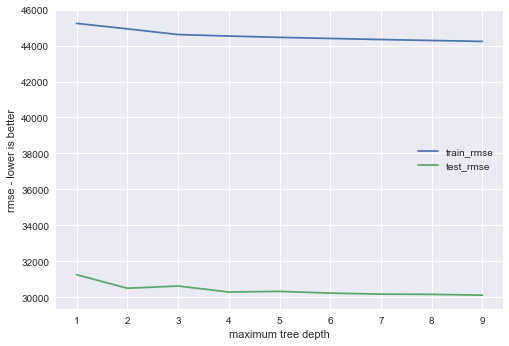

In [282]:
depths = range(1,10)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(metrics.mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(metrics.mean_squared_error(y_test,decision_tree.predict(X_test)))
    print("Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

The RMSE is several orders of magnitude lower when using decision trees as compared to linear regression. Therefore, it could be that it's a better fit for this dataset. However, the rmse is still pretty large. 

In [106]:
#remove ma
ma_data=data[data.state=='']

<bound method Series.unique of 13                               EntryLevel
14       BuildingConstruction/SkilledTrades
19                 Experienced(Non-Manager)
29                              Engineering
30                                      NaN
32                 Experienced(Non-Manager)
36                              Engineering
41                 Experienced(Non-Manager)
43                                      NaN
61       Manager(Manager/SupervisorofStaff)
64                 Experienced(Non-Manager)
68                 Experienced(Non-Manager)
80                                      NaN
82                                      NaN
83                 Experienced(Non-Manager)
88                                      NaN
100                Experienced(Non-Manager)
111                Experienced(Non-Manager)
117                Experienced(Non-Manager)
121                Experienced(Non-Manager)
127                                     NaN
134      Manager(Manager/SupervisorofStaff)
1

('Decision Tree RMSE:', 3.5944964539969266)


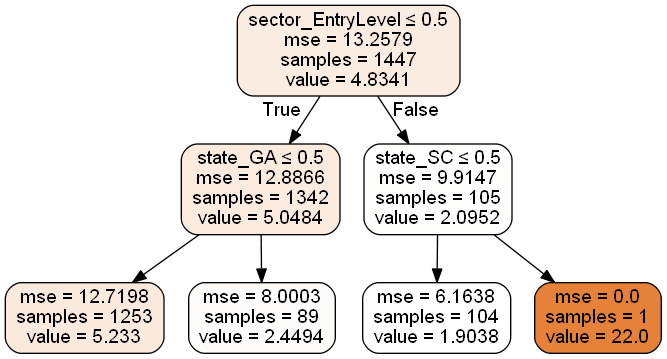

In [74]:
#remove the offending values from the dataset
data_cleaned=data[data.sector!='Experienced(Non-Manager)']
data_cleaned=data[data.sector!='Experienced(Non-Manager)']
#re-run the model

# Try the model using upper and lower ranges rather than midpoint
df3=pd.get_dummies(data_cleaned[['state','sector']],drop_first=True)


y2=data_cleaned['midpoint_salary']

# Split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df3,y2,test_size=.22)

decision_tree = DecisionTreeRegressor(max_depth=2, random_state=1)
decision_tree.fit(X_train,y_train)
print("Decision Tree RMSE:",np.sqrt(metrics.mean_squared_error(y_test,decision_tree.predict(X_test))))

#This allows us to make a decision tree real fast directly in the notebook!
dot_data = StringIO()  
export_graphviz(decision_tree, out_file=dot_data,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [32]:
data.ranges.unique

<bound method Series.unique of 13                  9.00 - 13.00 
14         80,000.00 - 95,000.00 
19         60,000.00 - 72,000.00 
29        70,000.00 - 100,000.00 
30                 62.00 - 81.00 
32        75,000.00 - 100,000.00 
36         68,000.00 - 72,000.00 
41         58,000.00 - 65,000.00 
43                 15.00 - 16.00 
61        45,000.00 - 100,000.00 
64         40,000.00 - 50,000.00 
68                 13.75 - 16.75 
80                 40.00 - 50.00 
82         80,000.00 - 90,000.00 
83         35,000.00 - 45,000.00 
88        80,000.00 - 100,000.00 
100        31,000.00 - 33,000.00 
111                50.00 - 65.00 
117      100,000.00 - 120,000.00 
121                17.00 - 22.00 
127       75,000.00 - 100,000.00 
134        56,000.00 - 64,000.00 
136                45.00 - 50.00 
137                25.00 - 27.00 
146       75,000.00 - 130,000.00 
182       60,000.00 - 110,000.00 
190       50,000.00 - 100,000.00 
201                12.00 - 12.00 
204        70,000